# RAISE.OSIA.IMAGE: ADVANCED PROCESSING

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

### Instructions

This assignment is to be completed individually or in pairs. A report is expected and must be submitted to the designated repository in MLS by the end of the second slot on October 14 at 5 p.m.</br>
The expected document is a Notebook or code+pdf report, the evaluation will take into account:
- use the image processing tools covered in class,
- illustration of results with visualization tools,
- take a step back and analyze the results.

### Objectives

The objectives of this practical assignment are multiple:
- to develop a lossy image compression algorithm that offers the best compromise between compression ratio and distortion
- to use basic ML methods to classify images based on well chosen features

1. Starting from a series of images in PPM format, propose a unique algorithm that allows all these images to be compressed with loss
while controlling distortion.
    1. Helps:
        1. Color spaces don't have same dynamics, use `np.clip()`, `.astype(np.uint8)` $\dots$
        1. You can use the dct: `from scipy.fftpack import dct` the direct DCT is `type=2`, the inverse DCT is `type=3`, to be fully reversible use `norm="ortho"`. Don't forget DCT is separable!
        1. You must save your compressed image in binary file not using image file format (JPEG, PNG, otherwise you will recompress it), use pickle!
        1. Don't try to save floating point numbers, to have better coding (without using Huffman code for instance) use `np.int16` for 16 bit unsigned integer for instance
    1. Illustrates your parameters tuning with plots and compare it with JPEG compression,  compression rate (original image size/ compressed image size in bits) vs. distortion PSNR, $\dots$
        1. The byte size of a file can be computed using `os.path.getsize("/path/to/myfile")`

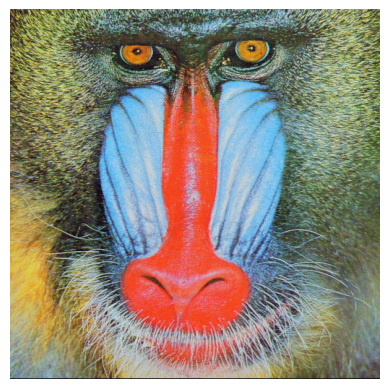

In [2]:
import imageio.v3 as iio
from scipy.fftpack import dct, idct


# Read image in PPM format
image = io.imread("content/DTC/Baboon.512.ppm")
img = np.array(image)
# Show it
plt.imshow(img)
plt.axis("off")
plt.show()

Conversion to YCbCr format

In [3]:
from scipy.fftpack import dct, idct

def dct2(block): # function to extract the dct from a given block
    return dct(dct(block.T, norm='ortho', type=2).T,norm='ortho', type=2)

def idct2(block): # function to invert the dct from a given block
    return dct(dct(block.T, norm='ortho', type=3).T,norm='ortho', type=3)

'''
Function responsible for encoding each of the 8x8 blocks of an image using DCT.
Before encoding, 128 is subtracted from each pixel in order to center the values
before applying the DCT, thus obtaining smaller values. DCT is then applied to each 8x8 block
and the result is divided by the quantization matrix q and rounded to retain only
the integer part of it.
Finally, the encode_matrix function is used to obtain the encoded vector of the matrix and
it is stored in the encoded_blocks matrix to be returned.
'''
def encoded_matrix_dct(img, q, block_size=8):
  h, w = img.shape
  dct_blocks = np.zeros_like(img, dtype=np.float32)
  encoded_blocks= np.empty((h//block_size, w//block_size), dtype=object)
  for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = img[i:i+block_size, j:j+block_size]
        block = block - 128
        dct_block = dct2(block)
        quantized_block = np.round(dct_block / q)
        dct_blocks[i:i+block_size, j:j+block_size] = quantized_block
        encoded_blocks[i//block_size, j//block_size] = encode_matrix(quantized_block)

  return encoded_blocks


'''
This function performs the opposite process to encoding. It receives the complete encoded matrix,
decodes each of the elements, applies IDCT, adds 128, and reconstructs the image.
'''
def encoded_matrix_idct(img, e_matrix, q, block_size=8):
  image = np.zeros_like(img)
  for i in range(e_matrix.shape[0]):
    for j in range(e_matrix.shape[1]):
      encoded_block = e_matrix[i:i+block_size, j:j+block_size]
      matriz_decoded = decode_matrix(e_matrix[i,j])
      dequantized_block = matriz_decoded * q
      image_block = idct2(dequantized_block)
      image_block = image_block + 128
      image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = image_block # Fixed indexing for image reconstruction
  return np.clip(image, 0, 255).astype(np.uint8)

# Fonctions pour encoder et décoder une matrice 8x8

The following functions are necessary to traverse the resulting DCT coefficient matrix after dividing it by Q, in order to subsequently perform compression:

* zigzag(matrix):
This function traverses the matrix in a zigzag pattern, starting with the upper left element, as this is the largest. Upon completing the traversal, it returns the resulting vector.
*   inv_zigzag(vec,n=8):
Taking a vector that would have been constructed with zigzag, this function allows you to obtain the matrix by reversing the process.

* rle_encode(vec):
This function takes a vector with the values obtained by the DCT/q matrix, which may be a vector obtained from the zigzag function, and encodes it in the form of tuples that describe (number of zeros before a number, the number itself). If it reaches the end with a string of several zeros in a row (something that often happens in a DCT/q vector), the tuple (‘EOB’,) is attached, indicating that what remains are zeros.
* rle_decode_ac(rle):
Following the logic of the encoder, in this case this function reads an array of tuples and decodes it to put it in the form of a vector with all the elements, ready for the inverse of the zigzag to be applied to obtain the 8x8 matrix.

* encode_matrix(matrix) and decode_matrix(encode) simply pair the previous zigzag+ rle_encode and dle_decode + inv_zigzag processes.

In [4]:
def zigzag(matrix):

    a = np.asarray(matrix)
    if a.ndim != 2 or a.shape[0] != a.shape[1]:
        raise ValueError("The matrix must be square (n x n).")
    n = a.shape[0]
    out = []
    for s in range(2 * n - 1):
        if s % 2 == 0:
            i = min(s, n - 1)
            i_end = max(0, s - (n - 1))
            while i >= i_end:
                j = s - i
                out.append(a[i, j])
                i -= 1
        else:
            i = max(0, s - (n - 1))
            i_end = min(s, n - 1)
            while i <= i_end:
                j = s - i
                out.append(a[i, j])
                i += 1
    return np.array(out)
def inv_zigzag(vec, n=8):
    v = np.asarray(vec).ravel()
    if v.size != n*n:
        raise ValueError(f"The vector must have length {n*n}, it has {v.size}.")
    out = np.empty((n, n), dtype=v.dtype)
    k = 0
    for s in range(2 * n - 1):
        if s % 2 == 0:
            i = min(s, n - 1)
            i_end = max(0, s - (n - 1))
            while i >= i_end:
                j = s - i
                out[i, j] = v[k]; k += 1
                i -= 1
        else:
            i = max(0, s - (n - 1))
            i_end = min(s, n - 1)
            while i <= i_end:
                j = s - i
                out[i, j] = v[k]; k += 1
                i += 1
    return out


def rle_encode(vec):
  out = []
  run = 0
  for i in range(len(vec)):
      if vec[i] == 0:
          run += 1
      else:
          # output (run, value)
          out.append((run, int(vec[i])))
          run = 0
  if run>0:
      out.append(('EOB',))   # end-of-block marker
  return out

def rle_decode_ac(rle):
    ac = []
    for token in rle:
        if token[0]=='EOB':
            # fill remaining with zeros to reach 63
            while len(ac)<64:
                ac.append(0)
            break
        run, val = token
        ac += [0]*run
        ac.append(val)
    # if still short, pad with zeros
    ac += [0]* (64 - len(ac))
    return np.array(ac)

def encode_matrix(matrix):
  vec = zigzag(matrix)
  encode = rle_encode(vec)
  return encode
def decode_matrix(encode):
  vec = rle_decode_ac(encode)
  decode = inv_zigzag(vec)
  return decode

In [5]:
import numpy as np
import gzip, pickle, os

# --- helpers de conversión a tipos "puros" de Python ---
def _to_python(obj):
    """Recursively converts numpy scalars/arrays/tuples to native Python types."""
    if obj is None:
        return None
    if isinstance(obj, (np.integer, np.floating, np.bool_)):
        return obj.item()
    if isinstance(obj, (list, tuple, np.ndarray)):
        return [_to_python(x) for x in obj]
    return obj

def to_serializable(encoded_blocks):
    """
    Converts np.array(dtype=object) of shape (bh, bw) to a list of lists of native objects.
    """
    bh, bw = encoded_blocks.shape
    out = []
    for i in range(bh):
        row = []
        for j in range(bw):
            blk = encoded_blocks[i, j]
            row.append(_to_python(blk))
        out.append(row)
    return out

def from_serializable(list_of_lists):
    """
    Rebuild np.array(dtype=object) from the list-of-lists structure.
    """
    arr = np.empty((len(list_of_lists), len(list_of_lists[0])), dtype=object)
    for i, row in enumerate(list_of_lists):
        for j, blk in enumerate(row):
            # convertir listas internas a tuplas si originalmente tus tokens eran tuplas
            # (opcional). Aquí dejamos los elementos tal cual (listas de listas).
            arr[i, j] = blk
    return arr

# --- guardar / cargar ---
def save_encoded_color(encoded_y, encoded_cb, encoded_cr, img_shape, q, block_size, path):

    payload = {
        "meta": {"img_shape": img_shape, "block_size": block_size, "q": q},
        "Y": to_serializable(encoded_y),
        "Cb": to_serializable(encoded_cb),
        "Cr": to_serializable(encoded_cr)
    }
    with gzip.open(path, "wb") as f:
        pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_encoded_color(path):
    with gzip.open(path, "rb") as f:
        payload = pickle.load(f)
    # Reconstruir en np.array(dtype=object) si lo prefieres:
    payload["Y"]  = from_serializable(payload["Y"])
    payload["Cb"] = from_serializable(payload["Cb"])
    payload["Cr"] = from_serializable(payload["Cr"])
    payload["q"] = from_serializable(payload["meta"]["q"])
    return payload


In [6]:
from skimage.color import rgb2ycbcr, ycbcr2rgb

def dtc_completo(img, q, nom, block_size=8):
  img_ycbcr = rgb2ycbcr(img)
  img_y = img_ycbcr[:,:,0]
  img_cb = img_ycbcr[:,:,1]
  img_cr = img_ycbcr[:,:,2]

  y_dct_coeficients = encoded_matrix_dct(img_y, q, block_size=8)
  cb_dct_coeficients = encoded_matrix_dct(img_cb, q, block_size=8)
  cr_dct_coeficients = encoded_matrix_dct(img_cr, q, block_size=8)

  save_encoded_color(y_dct_coeficients, cb_dct_coeficients, cr_dct_coeficients, img.shape, q, block_size, nom)

  data = load_encoded_color(nom)

  y_decompressed = encoded_matrix_idct(img_y,data["Y"], q, block_size=8)
  cb_decompressed = encoded_matrix_idct(img_cb, data["Cb"], q, block_size=8)
  cr_decompressed = encoded_matrix_idct(img_cr, data["Cr"], q, block_size=8)


  new_ycbcr = np.zeros_like(img_ycbcr)
  new_ycbcr[:,:,0] = y_decompressed
  new_ycbcr[:,:,1] = cb_decompressed
  new_ycbcr[:,:,2] = cr_decompressed
  new_rgb = ycbcr2rgb(new_ycbcr)
  new_rgb = np.clip(new_rgb, 0, 255).astype(np.uint8)
  return new_rgb

In [7]:
def dtc_completo_descompress(img, q, nom, block_size=8):
  data = load_encoded_color(nom)
  new_ycbcr = np.zeros_like(img)
  new_ycbcr[:,:,0] = data["Y"]
  new_ycbcr[:,:,1] = data["Cb"]
  new_ycbcr[:,:,2] = data["Cr"]
  new_rgb = ycbcr2rgb(new_ycbcr)
  new_rgb = np.clip(new_rgb, 0, 1)
  new_rgb = (new_rgb * 255).astype(np.uint8)

In [8]:
'''
This will serve as a reference, as it is the quantization matrix implemented by
the JPEG algorithm.

'''

q_jpeg =  np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.int16)

new_jpeg = dtc_completo(img, q_jpeg, "content/DTC/jpeg", block_size=8)

In order to compare the results, the PSNR (Peak Signal-to-Noise Ratio) is calculated, an indicator that uses least squares to get an idea of how different one image is from another. Since the human eye cannot always detect these differences, this function will be useful for comparing the performance of different Q values.


In [9]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [10]:
import os
'''
The change in size is calculated with respect to the base image Baboon.512.ppm
in order to compare the compression capacity for different values of q.
'''
original_size = os.path.getsize("content/DTC/Baboon.512.ppm")
jpg_size = os.path.getsize("content/DTC/jpeg")
jpg_ratio = original_size/jpg_size
jpg_psnr = calculate_psnr(img, new_jpeg)
print(f"JPEG: PSNR={jpg_psnr:.2f}, ratio={jpg_ratio:.2f}")

JPEG: PSNR=5.31, ratio=5.79


In order to obtain more efficient q values than jpeg, the random test is performed 200 times for different values of a and b, these being the coefficients used to define the values of a q matrix,
for each element of the matrix q[i,j] = a+ b*i+b*j.

# Generation of new compressed random images 

In [ ]:
np.random.seed(42)
a_bs = []
qs = []
new_img =[]
for i in range(200):
  a = np.random.randint(3, 100)
  b = np.random.randint(1, 40)
  q_n = np.zeros((8, 8), dtype=int)
  for i in range(8):
    for j in range(8):
      q_n[i,j] = a+b*i+b*j
  a_bs.append([a,b])
  qs.append(q_n)
  new_img.append(dtc_completo(img, q_n, f"content/DTC/q_a{a}_b{b}", block_size=8))


'''
The size ratio and PSNR of each of the generated images are calculated and stored in
the corresponding lists.
'''
ratios = []
psnrs = []
i =0
for a,b in a_bs:
  img_size = os.path.getsize(f"content/DTC/q_a{a}_b{b}")
  ratio = original_size/img_size
  ratios.append(ratio)
  new_psnr = calculate_psnr(img, new_img[i])
  psnrs.append(new_psnr)
  i+=1



Decoding and obtaining characteristics of each of the images 

In [55]:
path = "content/DTC/q_a3_b8"
data = load_encoded_color(path)
q = data["q"]
new_img = dtc_completo_descompress(img, q, path, block_size=8)
img_size = os.path.getsize(path)
ratio = original_size/img_size
b = calculate_psnr(img, new_img)


new_rgb before clipping: [[[ 2.38097774e-03  7.29019249e-04  9.16466225e-03]
  [ 1.32448210e-03 -3.57600402e-04  8.26327868e-03]
  [ 1.09169389e-03  7.53142545e-04  1.11249260e-03]
  ...
  [ 1.83312318e-03  4.28445596e-04  8.85066593e-03]
  [ 8.47272341e-03 -2.24465163e-03  8.97021459e-03]
  [ 9.17571539e-03 -1.41936679e-03  9.47411682e-03]]

 [[ 1.87958998e-03  2.15581882e-04  8.72531931e-03]
  [ 1.23494855e-03 -4.23034737e-04  8.04965548e-03]
  [ 9.48440210e-04  6.52062488e-04  7.52082030e-04]
  ...
  [ 2.19125738e-03  6.84158138e-04  9.73618113e-03]
  [ 8.09668271e-03 -2.77733722e-03  9.40075660e-03]
  [ 7.95805953e-03 -2.83584116e-03  9.28020055e-03]]

 [[ 1.52145587e-03 -1.60626635e-04  8.46025244e-03]
  [ 1.48564242e-03 -1.42216859e-04  8.14523728e-03]
  [ 1.12750841e-03 -6.44946150e-04  8.53164116e-03]
  ...
  [ 1.29592208e-03 -2.05152366e-04  8.80982341e-03]
  [ 7.64901508e-03 -3.26115367e-03  9.13922344e-03]
  [ 7.94015288e-03 -2.92002066e-03  9.60354043e-03]]

 ...

 [[ 8.106

In [40]:
import os
import numpy as np

ratios = []
psnrs = []
for i in range(3,100):
  for j in range(1,40):
    if os.path.exists(f"content/DTC/q_a{i}_b{j}"):
      path = f"content/DTC/q_a{i}_b{j}"
      data = load_encoded_color(path)
      q = data["q" ]
      print(f"Obteniendo datos de la imagen a_{i}, b_{j}. su q es {q}")
      new_img = dtc_completo_descompress(img, q, path, block_size=8)
      img_size = os.path.getsize(path)
      ratio = original_size/img_size
      ratios.append(ratio)
      new_psnr = calculate_psnr(img, new_img[i])
      psnrs.append(new_psnr)

Obteniendo datos de la imagen a_3, b_8. su q es [[np.int64(3) np.int64(11) np.int64(19) np.int64(27) np.int64(35)
  np.int64(43) np.int64(51) np.int64(59)]
 [np.int64(11) np.int64(19) np.int64(27) np.int64(35) np.int64(43)
  np.int64(51) np.int64(59) np.int64(67)]
 [np.int64(19) np.int64(27) np.int64(35) np.int64(43) np.int64(51)
  np.int64(59) np.int64(67) np.int64(75)]
 [np.int64(27) np.int64(35) np.int64(43) np.int64(51) np.int64(59)
  np.int64(67) np.int64(75) np.int64(83)]
 [np.int64(35) np.int64(43) np.int64(51) np.int64(59) np.int64(67)
  np.int64(75) np.int64(83) np.int64(91)]
 [np.int64(43) np.int64(51) np.int64(59) np.int64(67) np.int64(75)
  np.int64(83) np.int64(91) np.int64(99)]
 [np.int64(51) np.int64(59) np.int64(67) np.int64(75) np.int64(83)
  np.int64(91) np.int64(99) np.int64(107)]
 [np.int64(59) np.int64(67) np.int64(75) np.int64(83) np.int64(91)
  np.int64(99) np.int64(107) np.int64(115)]]
Obteniendo datos de la imagen a_3, b_12. su q es [[np.int64(3) np.int64(15) n

We define that in order for us to say that q is obtaining a better result than jpeg, it must comply with or have better image quality with the same or less weight, or weigh less with better or equal image quality.
Taking this into account, the values obtained with jpeg are compared and improvements are proposed.

In [38]:
sizes = original_size / np.array(ratios)

efficient_idx = []
for i in range(len(ratios)):
    if (psnrs[i] > jpg_psnr and sizes[i] <= jpg_size) or \
       (abs(psnrs[i] - jpg_psnr) < 1e-3 and sizes[i] < jpg_size):
        efficient_idx.append(i)

# Mostrar resultados
if efficient_idx:
    print(f"✅ {len(efficient_idx)} options more efficient than JPEG were found\n")
    for i in efficient_idx:
        a, b = a_bs[i]
        print(f" - a={a}, b={b} | Ratio={ratios[i]:.2f}, PSNR={psnrs[i]:.2f} dB | Size={sizes[i]:.0f} bytes")
else:
    print("❌ No option more efficient than JPEG was found according to the new criteria.")

❌ No option more efficient than JPEG was found according to the new criteria.


We show in a graph the relationship between PSNR and the size of each image, where we differentiate between cases that meet our efficiency condition.

5.785378520932491 24.407827


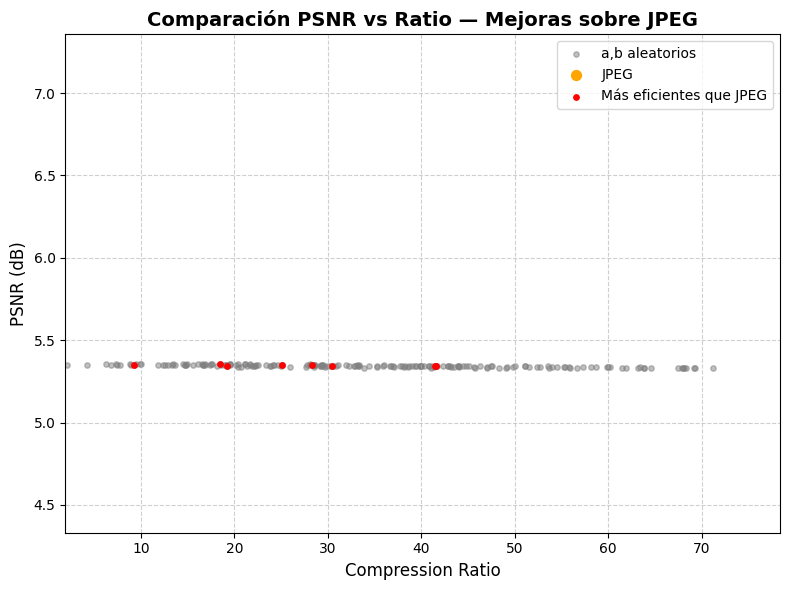

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Puntos generales (todos)
plt.scatter(ratios, psnrs, color='gray', s=15, alpha=0.5, label='a,b aleatorios')

# JPEG como referencia
plt.scatter(jpg_ratio, jpg_psnr, color='orange', s=50, marker='o', label='JPEG')
print(jpg_ratio, jpg_psnr)
# Marcar las opciones eficientes (si existen)
if efficient_idx:
    plt.scatter(np.array(ratios)[efficient_idx], np.array(psnrs)[efficient_idx],
                color='red', s=15, marker='o', label='Más eficientes que JPEG')


plt.title("Comparación PSNR vs Ratio — Mejoras sobre JPEG", fontsize=14, fontweight='bold')
plt.xlabel("Compression Ratio", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Límites automáticos
plt.xlim(min(ratios)*0.9, max(ratios)*1.1)
plt.ylim(min(psnrs)-1, max(psnrs)+2)

plt.tight_layout()
plt.show()

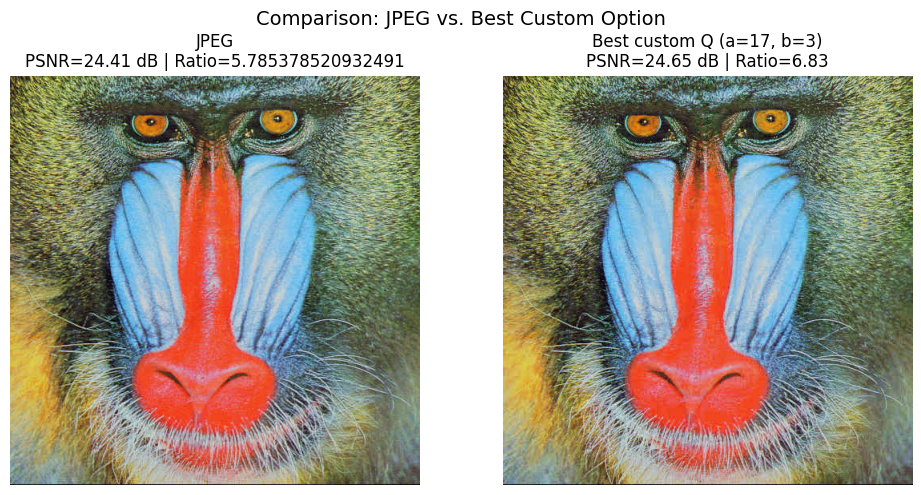

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- encontrar la mejor opción entre las más eficientes ---
if efficient_idx:
    # elegir la que tenga el mayor PSNR
    best_idx = max(efficient_idx, key=lambda i: psnrs[i])
    a_best, b_best = a_bs[best_idx]
    best_img = new_img[best_idx]

    # información asociada
    best_psnr = psnrs[best_idx]
    best_ratio = ratios[best_idx]
    best_size = sizes[best_idx]

    # --- mostrar comparación visual ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(np.clip(new_jpeg, 0, 255).astype(np.uint8))
    axes[0].set_title(f"JPEG\nPSNR={jpg_psnr:.2f} dB | Ratio={jpg_ratio}")
    axes[0].axis("off")

    axes[1].imshow(np.clip(best_img, 0, 255).astype(np.uint8))
    axes[1].set_title(f"Best custom Q (a={a_best}, b={b_best})\n"
                      f"PSNR={best_psnr:.2f} dB | Ratio={best_ratio:.2f}")
    axes[1].axis("off")

    plt.suptitle("Comparison: JPEG vs. Best Custom Option", fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print("❌ No options more efficient than JPEG were found.")


Thanks to this random method a and b, several values a and b were obtained, which allow for greater compression than the JPEG format while weighing the same or less.

2. Image recognition: Digit recognition
    1. Direct Image classification
        1. Load the dataset and display some images
        1. Use the whole image as features to train and test some basics ML methods (from scikit-learn). Display results and comment.

    1. Image features
        1. Choose one PPM image and compute the HOG (Histogram of Gradient Feature, first introduced by Dalal and Triggs in 2005 as a robust feature extraction method), `hog_feature, hog_image = feature.hog(img, visualize=True)`, display the `hog_feature` as histogram and `hog_image` as image. Your image is in color so you should use `channel_axis=2`. As default parameters you can use: `pixels_per_cell=(16, 16), cells_per_block=(1, 1)`.
        HOG features can be seen as edge descriptors computed by bloc and then aggregated into an histogram.
        1. Use HOG features for the images and classify using the same set up.
        1. Suppose we compress the test dataset (with JPEG QF=75), and classify using the same set up, what can we expect?  

In [19]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [20]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)


In [22]:
def display_image(image_data, label=None, pred=None):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    title = ""
    if label is not None:
        title += f"Label: {label}"
    if pred is not None:
        title += f" | Pred: {pred}"
    if title:
        plt.title(title)
    plt.show()

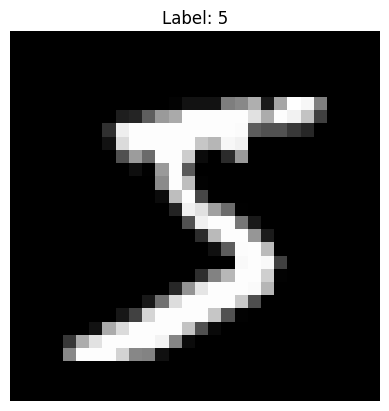

In [23]:
display_image(mnist.data[0], mnist.target[0])

In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # solo para mostrar barra de progreso

# --- 1️⃣ Cargar y preparar los datos ---
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)
X = X / 255.0


X, y = X[:10000], y[:10000]

# ---  Configurar KFold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ---  Entrenar modelos ---
models = {
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree (Gini)": DecisionTreeClassifier(criterion='gini', random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=5, gamma=0.05)
}

# --- 4 Evaluar cada modelo ---
results = {name: [] for name in models.keys()}

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"\n🔹 Fold {fold}")
    for name, model in models.items():
        print(f"  Entrenando {name}...", end="")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name].append(acc)
        print(f" -> Accuracy: {acc:.4f}")


summary = pd.DataFrame({
    "Modelo": list(results.keys()),
    "Accuracy promedio": [np.mean(accs) for accs in results.values()],
    "Desviación estándar": [np.std(accs) for accs in results.values()]
})

print("\n Resultados comparativos (K-Fold=5):")
print(summary.to_string(index=False))


🔹 Fold 1
  Entrenando KNN (k=3)... -> Accuracy: 0.9500
  Entrenando Decision Tree (Gini)... -> Accuracy: 0.8245
  Entrenando SVM (RBF)... -> Accuracy: 0.9695

🔹 Fold 2
  Entrenando KNN (k=3)... -> Accuracy: 0.9485
  Entrenando Decision Tree (Gini)... -> Accuracy: 0.8055
  Entrenando SVM (RBF)... -> Accuracy: 0.9685

🔹 Fold 3
  Entrenando KNN (k=3)... -> Accuracy: 0.9460
  Entrenando Decision Tree (Gini)... -> Accuracy: 0.8080
  Entrenando SVM (RBF)... -> Accuracy: 0.9695

🔹 Fold 4
  Entrenando KNN (k=3)... -> Accuracy: 0.9435
  Entrenando Decision Tree (Gini)... -> Accuracy: 0.8085
  Entrenando SVM (RBF)... -> Accuracy: 0.9625

🔹 Fold 5
  Entrenando KNN (k=3)... -> Accuracy: 0.9430
  Entrenando Decision Tree (Gini)... -> Accuracy: 0.8170
  Entrenando SVM (RBF)... -> Accuracy: 0.9600

 Resultados comparativos (K-Fold=5):
              Modelo  Accuracy promedio  Desviación estándar
           KNN (k=3)             0.9462             0.002731
Decision Tree (Gini)             0.8127      

3. Photographic mosaic. The idea is to generate a large mosaic image from a large database of small images called thumbnails. The principle of the method consists of taking a large image, cutting it into small blocks, and replacing each block of the large image with the most similar thumbnail from the large thumbnail database. https://en.wikipedia.org/wiki/Photographic_mosaic
    1. Chose a large image
    1. Get a large image dataset from internet
    1. Split your image into blocs. What is a good bloc size?
    1. Compute a criteria for each bloc (first try the mean value), it will be used to match with thumbnails
    1. Display the bloc image, where each bloc of the image is replaced by the criteria
    1. Generate the mosaic by replacing each bloc of the image by the resized image that minimize the distance between their critaria values
    1. What criteria could be used instead? With witch distance? Try it!